# NoteBook to explain how to use the defocus measurement procedure from titlted mask UV images.




# Initialization:

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
from __future__ import division
import os, sys
from IPython.display import Image as imdisplay

from Calibration_SW.focustest import *

insert here the local path to your ouwcloud files (the root of FireBall owncloud):

In [6]:
cloudpath = '/home/dvibert/ownCloud/FIREBALL/'

# Detect and measure the spots sizes

this will detect the spots, measure their FWHM and compare with prediction from model to assign a wavelength





      START IMAGE ANALYSIS 




reading parameters...
centre = None
To extract the sources: fwhm = [5, 7, 9, 12.5, 15], threshold = [50, 20, 10]
reading parameters...
Computing predicted location for grid mask
Location of the sources predicted
fwhm = 5, T = 50, len = 25
fwhm = 5, T = 20, len = 73
fwhm = 5, T = 10, len = 144
fwhm = 7, T = 50, len = 49
fwhm = 7, T = 20, len = 126
fwhm = 7, T = 10, len = 200
fwhm = 9, T = 50, len = 67
fwhm = 9, T = 20, len = 167
fwhm = 9, T = 10, len = 237
fwhm = 12.5, T = 50, len = 112
fwhm = 12.5, T = 20, len = 211
fwhm = 12.5, T = 10, len = 240
fwhm = 15, T = 50, len = 123
fwhm = 15, T = 20, len = 223
fwhm = 15, T = 10, len = 239
Number of sources detected:  242
We fit the profile by a gaussian
Fitting in spectral direction


/opt/anaconda3/envs/FireBallPipe2018/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/anaconda3/envs/FireBallPipe2018/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting in spectral direction


<IPython.core.display.Javascript object>


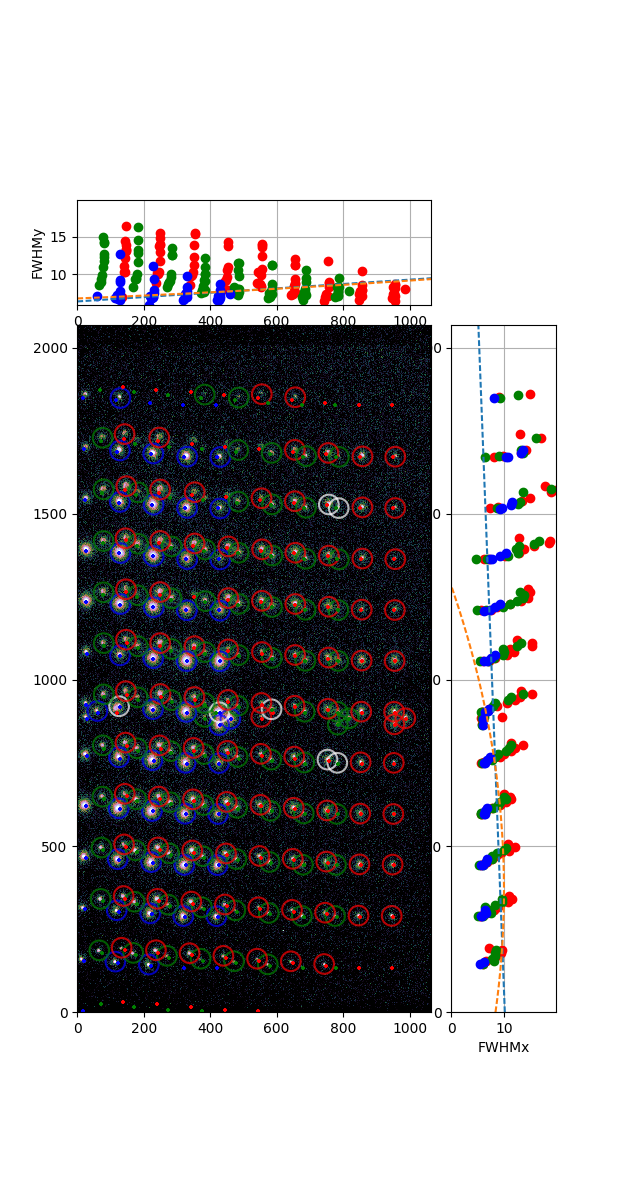

In [7]:
filename = cloudpath + 'Tests-at-FortSumner/170901_perf3.0/170901/focus/image000103stack.fits'
GridMask = Focus(filename = filename, quick=False, figsize=12, windowing=True, mask='grid', cloudpath=cloudpath)


In [ ]:
GridMask.table

In [ ]:
GridMask.predictedSpots

playing with the windowing thresholds to assign more slits/wavelength

<IPython.core.display.Javascript object>


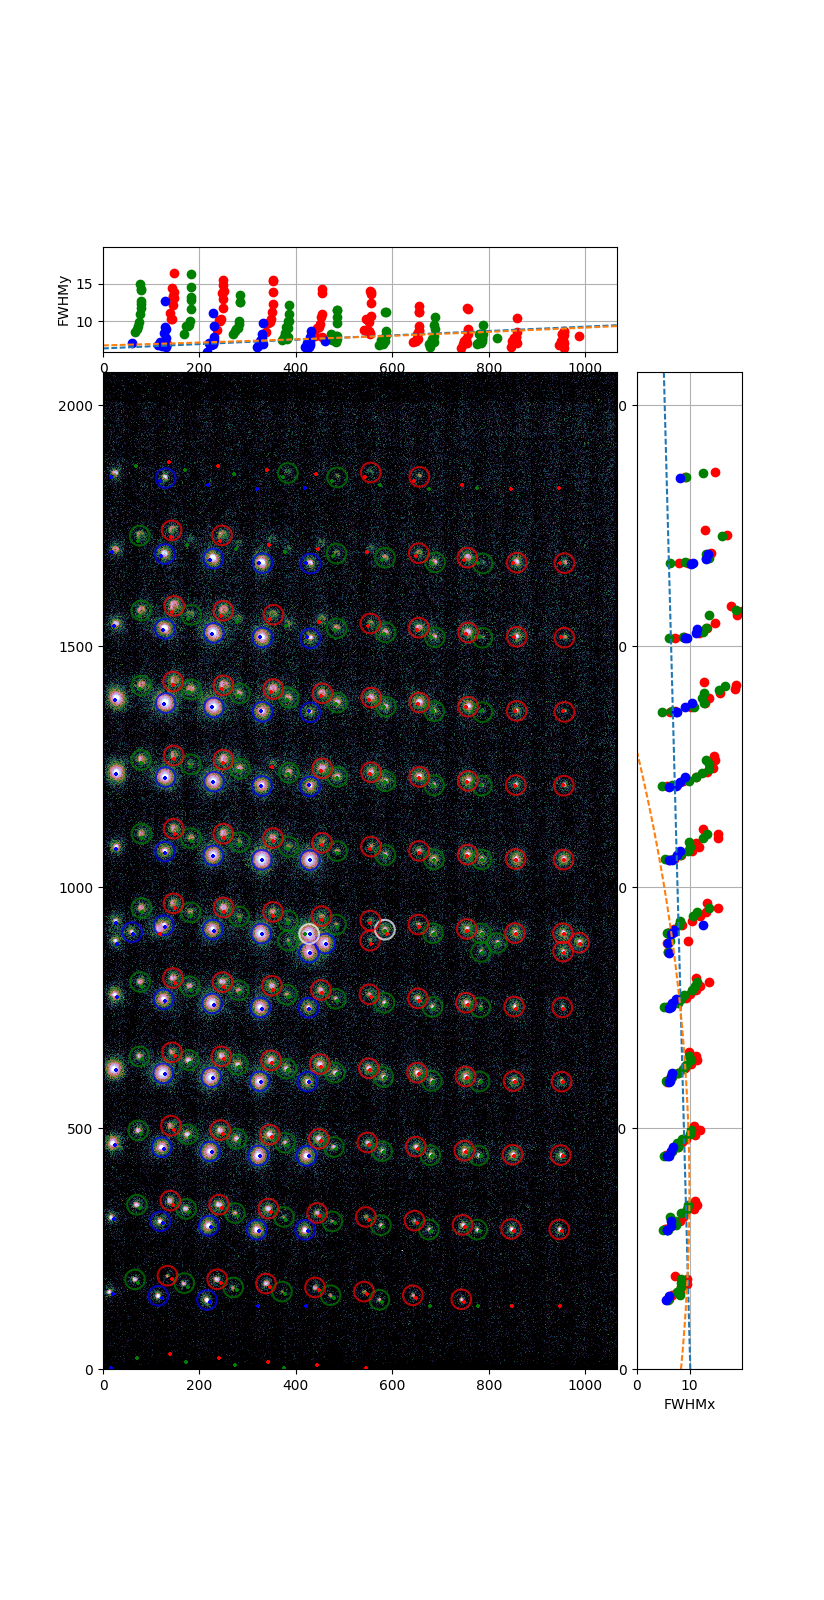

In [8]:
GridMask.AsignWave2Spot(dist_min=20, dist_max=15)
GridMask.plot_FWHM_det()

# Analyze the focus

To do so one first need to compute the polynomial mapping between the known mask coordinates and the measured one on the detector:

## mask-detector mapping

In [9]:
help(GridMask.map_mask_detector)

Help on method map_mask_detector in module Calibration_SW.focustest:

map_mask_detector(self, deg=[5, 2], bywave=True, plot=False) method of Calibration_SW.focustest.Focus instance
    From a table of observed mask slits (or holes) on the detector, 
    determine the mapping from science mask coord in mm to detector coord in mm
    and compute as well, the mask center position on the detector for each wavelength
    
    Focus.map_mask_detector(deg=[5, 2], bywave=True, plot=False)
    
        deg: degree of polynome [deg_x, deg_y]
        
        bywave: if True (default) perform a mapping by wavelength
                else include w in the fit (deg 2)
                
        plot: if True plot the residual vectors
        
    return the array of centers  the array of polynomial coeffs.



at wavelength: 0.20261371
maximum residual along x, y (in pixels): 2.82764128447, 3.82702298789
at wavelength: 0.20626604
maximum residual along x, y (in pixels): 2.64850245262, 2.79841733193
at wavelength: 0.21392365
maximum residual along x, y (in pixels): 1.67342825103, 2.37453358904


<IPython.core.display.Javascript object>


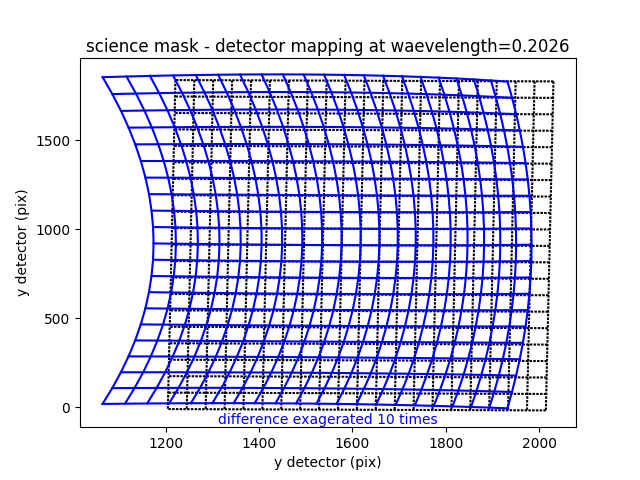

<IPython.core.display.Javascript object>


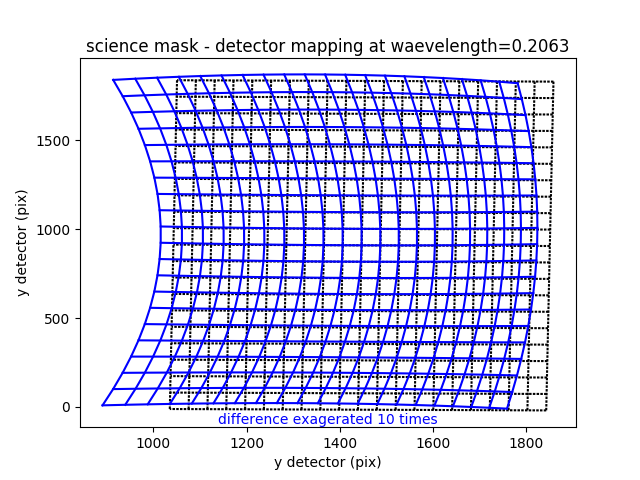

<IPython.core.display.Javascript object>


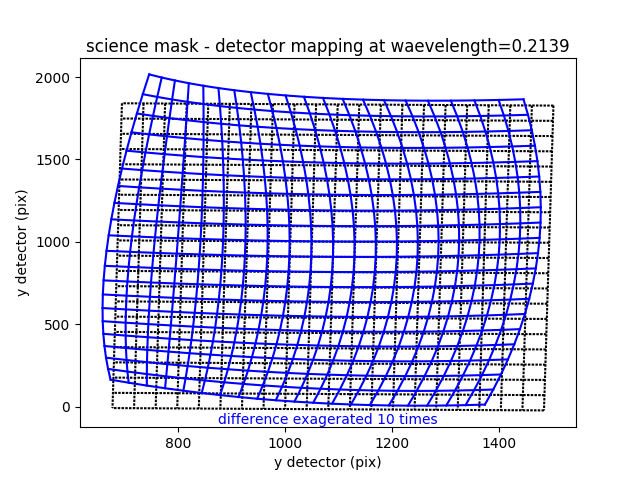

In [10]:
map_cooefs, centers = GridMask.map_mask_detector(deg=[2,2])
GridMask.plot_mapping()

### magnification at center of mask

In [21]:
dxdet_dxmask = map_cooefs[:,1,0,0]
dxdet_dymask = map_cooefs[:,0,1,0]
dydet_dxmask = map_cooefs[:,1,0,1]
dydet_dymask = map_cooefs[:,0,1,1]
J  = np.array([[dxdet_dxmask, dxdet_dymask],[dydet_dxmask, dydet_dymask]])
# convert det pix in mm
J *= 13*1E-3
print(J[...,0])
print(J[...,1])
print(J[...,2])

[[-0.0087932  -0.87643434]
 [-1.00183347  0.00808349]]
[[-0.00840329 -0.87569545]
 [-1.00176221  0.00842714]]
[[-0.00960993 -0.87602361]
 [-1.00185777  0.01523229]]


In [25]:
dxdet_dymask*13*1E-3

array([-0.87643434, -0.87569545, -0.87602361])

In [23]:
1./0.876

1.1415525114155252

## Estim defocus

Then analyze the focus by fitting the FWHM of the spots in the field with a parbolic cylinder.
Use the estim_focus_tilted_mask procedure:

In [11]:
help(estim_focus_tilted_mask)

Help on function estim_focus_tilted_mask in module Calibration_SW.focustest:

estim_focus_tilted_mask(focus, tilt=4.0, xmask0=0.0, fit_yslope=True, use_mapped_det=False, plot=False)
    Estim detector focus from tilted mask by fitting parabolic cylinder
    
        estim_focus_tilted_mask(focus, tilt=4., xmask0=0., fit_yslope=True,
                                use_mapped_det=False, plot=False)
        
            focus: is an instance of Focus object (image with spots detected 
                                                   and measured)
            
            tilt: angle of mask in degree (default to 4.)
            
            xmask0: position on the mask (in mm) where the tilted mask cross 
                    the focal sphere (default to 0)
            
            fit_yslope: boolean, if True fit the detector y slope 
                        (default to True)
            
            use_mapped_det: boolean, if True use mapped coordinates of the spots
                 


        detector focus fitted at wavelength 0.20261371:
              offset: -7.52126252573  +-2.58641211009
              xslope: 0.00195717008176  +-0.000188695554002
              yslope: 0.0  +-0.0
              a: 0.66841013736  +-0.388318411345
              b: 1.39632433142  +-7.43758191203
              


<IPython.core.display.Javascript object>


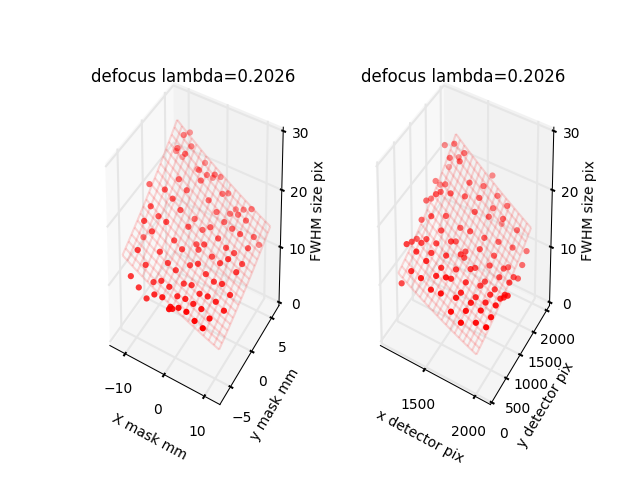


        detector focus fitted at wavelength 0.20626604:
              offset: -4.76055097859  +-0.442222944898
              xslope: 0.0021179239649  +-0.000166141945277
              yslope: 0.0  +-0.0
              a: 1.62224271368  +-0.335209201654
              b: 8.47138432854  +-0.800485214541
              


<IPython.core.display.Javascript object>


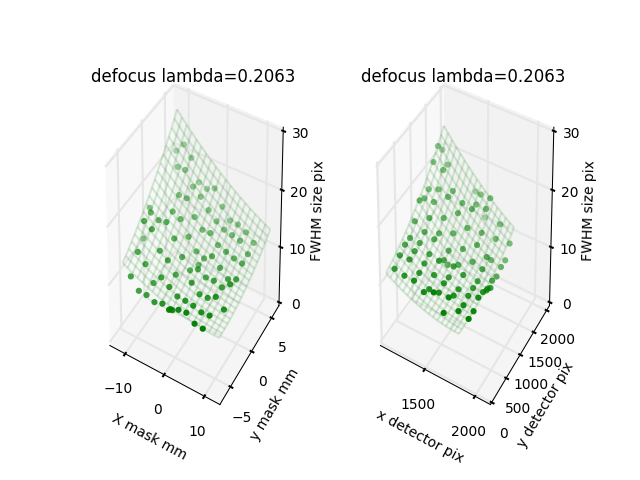


        detector focus fitted at wavelength 0.21392365:
              offset: -2.72307560965  +-1.02023360859
              xslope: 0.00127539004325  +-0.000484478891438
              yslope: 0.0  +-0.0
              a: 1.83725906134  +-1.09205976901
              b: 8.36758895329  +-1.2334117329
              


<IPython.core.display.Javascript object>


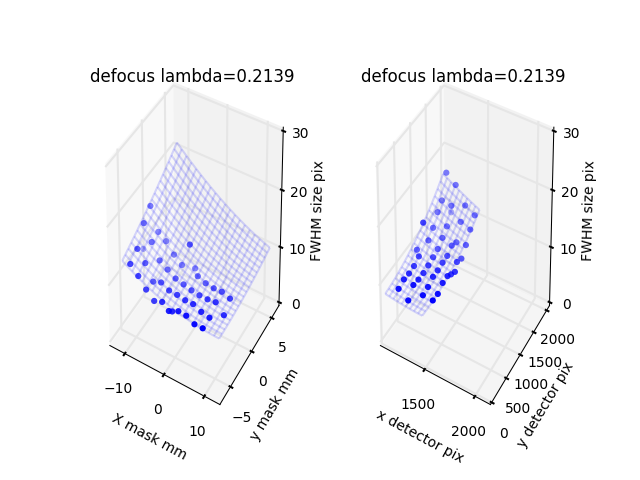


    detector focus fitted jointly at all wavelength :
          offset: 0.21392365  +--4.36132452402
          xslope: 1.20674638246  +-0.00139382216124
          yslope: 0.0  +-0.0
          a: 0.00019737530603  +-1.08960078671
          b: 0.552779395415  +-7.34701418916
          


<IPython.core.display.Javascript object>


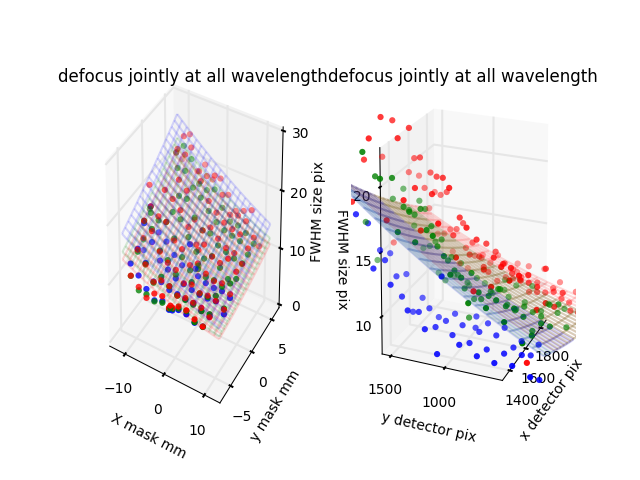

In [12]:
estim_focus_tilted_mask(GridMask, fit_yslope=False, plot=True)

## move mask on carrousel

In [ ]:
newx,newy = GridMask.rotate_pa_mask(pa=3., R=125.)
map_cooefs, centers = GridMask.map_mask_detector(deg=[2,2])
# we need an image with rotated mask
#estim_focus_tilted_mask(GridMask, fit_yslope=False, plot=True)